# **ATLAS** : Academic Task and Learning Agent System

## **Overview**
ATLAS demonstrates how to build an intelligent multi-agent system that transforms the way students manage their academic life. Using LangGraph's workflow framework, we'll create a network of specialized AI agents that work together to provide personalized academic support, from automated scheduling to intelligent lectures summarization.

## **Motivation**
Today's students face unprecedented challenges managing their academic workload alongside digital distractions and personal commitments. Traditional study planning tools often fall short because they:

- Lack intelligent adaptation to individual learning styles
- Don't integrate with students' existing digital ecosystems
- Fail to provide context-aware assistance
- Miss opportunities for proactive intervention

**ATLAS** addresses these challenges through a sophisticated multi-agent architecture that combines advanced language models with structured workflows to deliver personalized academic support.
##**Key Components**
- Coordinator Agent: Orchestrates the interaction between specialized agents and manages the overall system state
- Planner Agent: Handles calendar integration and schedule optimization
- Notewriter Agent: Processes academic content and generates study materials
- Advisor Agent: Provides personalized learning and time management advices

## **Implementation Method**
1. The workflow begins by assessing the student's needs and learning style.
2. It creates personalized study plans based on course requirements.
3. Provides research assistance and resource recommendations.
4. Adapts content delivery to match the student's learning style.
5. Tracks progress and adjusts recommendations accordingly.

The entire process is orchestrated using LangGraph, which manages the flow of information between different components and ensures that each step supports the student's academic goals effectively.

## **Conclusion**
ATLAS : Academic Task and Learning Agent System demonstrates the potential of combining language models with structured workflows to create an effective educational support system. By breaking down the academic support process into discrete steps and leveraging AI capabilities, we can provide personalized assistance that adapts to each student's needs. This approach opens up new possibilities for AI-assisted learning and academic success.






## **Agents Design**

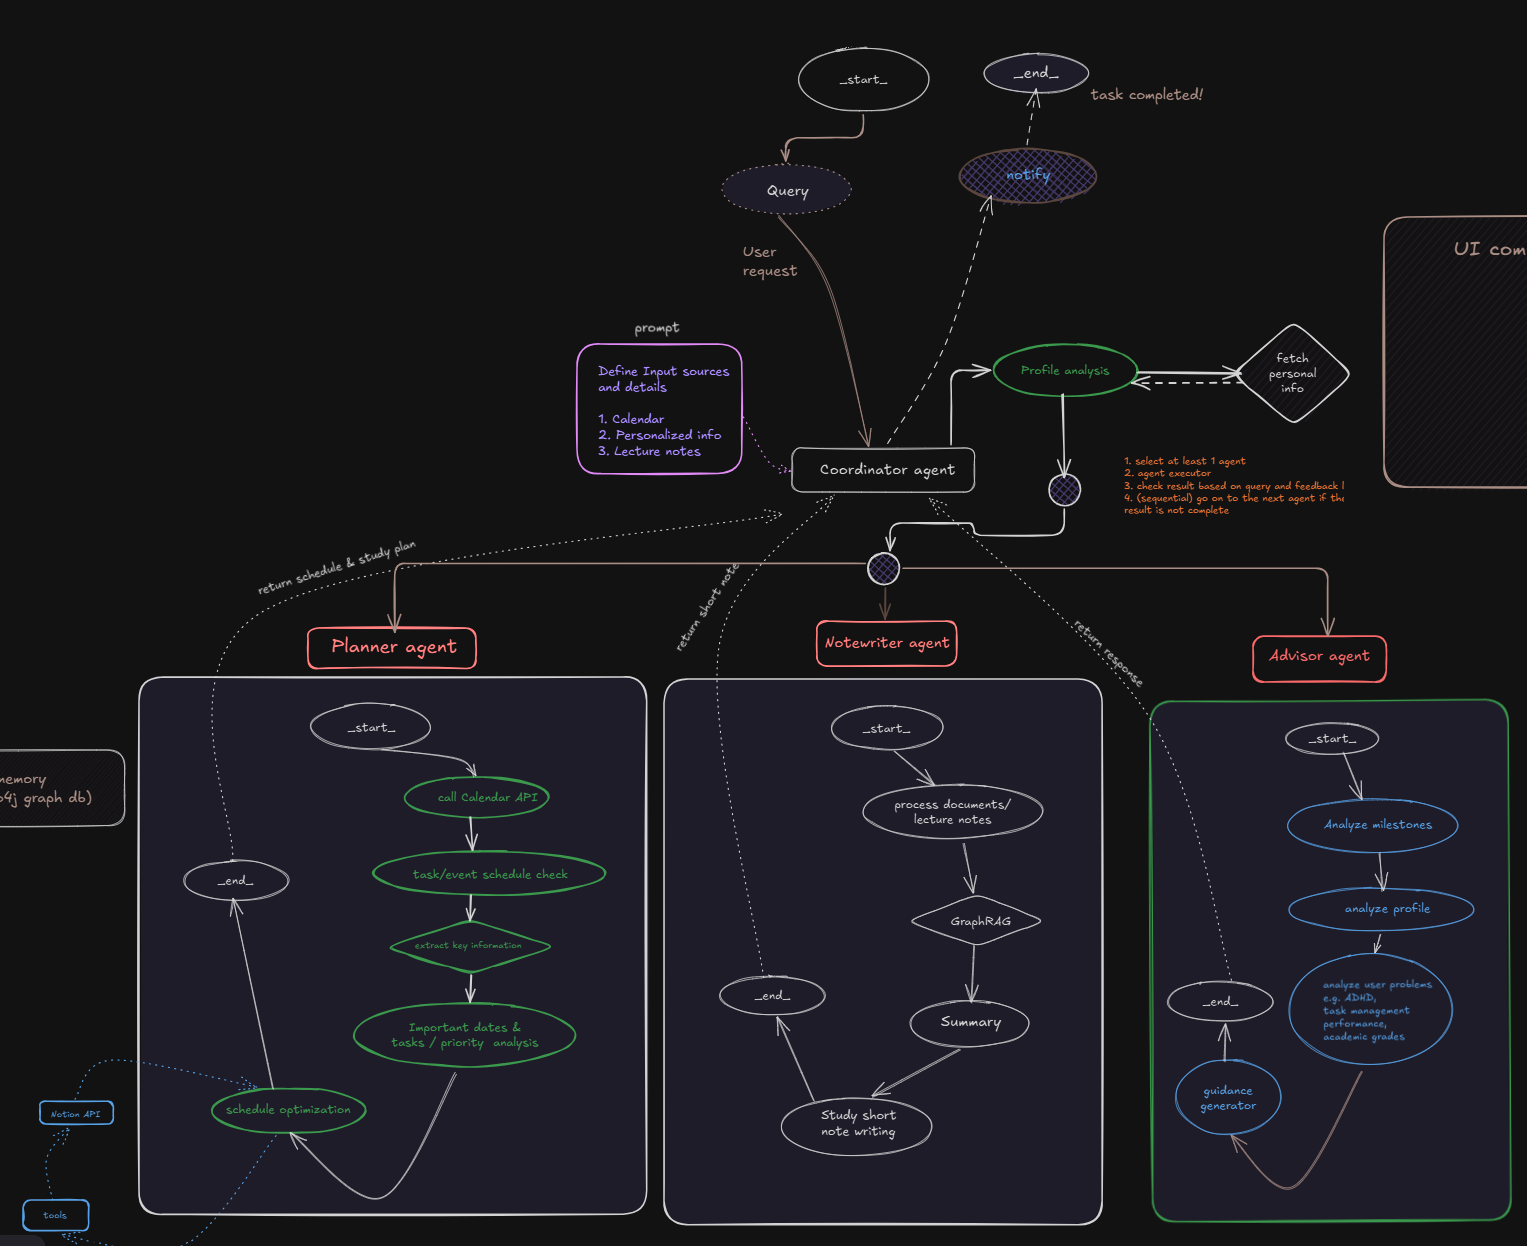

## Imports

Import all necessary modules and libraries

In [ ]:
%%capture
!pip install langgraph langchain langchain-openai openai python-dotenv

In [ ]:
## Graph Visualization
!sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config
!pip install graphviz
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pkg-config is already the newest version (0.29.2-1ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04.1).
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
#Utilities
from typing import Annotated, List, Dict, TypedDict, Literal, Optional, Callable, Set, Tuple, Any, Union
from datetime import datetime, timezone, timedelta
import asyncio
from pydantic import BaseModel, Field
from operator import add
from IPython.display import Image, display
from google.colab import files
import json
import re
import os
# Core imports
from openai import OpenAI, AsyncOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langchain.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, Graph, END, START

# Markdown
from rich.console import Console
from rich.markdown import Markdown
from rich.panel import Panel
from rich.text import Text


## API Configuration
Set up the API keys for the LLM provider (Nemotron-4-340B).

For Google Colab:
1. Add your API key to Colab secrets
2. Name the secret 'NEMOTRON_4_340B_INSTRUCT_KEY'

For local development:
1. Create a .env file
2. Add: NEMOTRON_4_340B_INSTRUCT_KEY=your_api_key


In [ ]:
NEMOTRON_4_340B_INSTRUCT_KEY = None #initialize global variable

In [ ]:
def configure_api_keys():
    """Configure and verify API keys for LLM services."""
    # load_dotenv()
    # api_key = os.getenv("NEMOTRON_4_340B_INSTRUCT_KEY")

    #Check Google Colab secrets
    from google.colab import userdata
    global NEMOTRON_4_340B_INSTRUCT_KEY
    NEMOTRON_4_340B_INSTRUCT_KEY = userdata.get('NEMOTRON_4_340B_INSTRUCT_KEY')
    # Set environment variable
    os.environ['NEMOTRON_4_340B_INSTRUCT_KEY'] = NEMOTRON_4_340B_INSTRUCT_KEY
    # Print configuration status
    is_configured = bool(os.getenv("NEMOTRON_4_340B_INSTRUCT_KEY"))
    print(f"API Key configured: {is_configured}")
    return is_configured

api_configured = configure_api_keys()
if not api_configured:
    print("\nAPI key not found. Please ensure you have:")
    print("1. Set up your API key in Google Colab secrets, or")
    print("2. Created a .env file with NEMOTRON_4_340B_INSTRUCT_KEY")

API Key configured: True


## State Definition

Define the AcademicState class to hold the workflow's state.

In [ ]:
class AcademicState(TypedDict):
   """Master state container for the academic assistance system"""
   messages: Annotated[List[BaseMessage], add]   # Conversation history
   profile: dict                                 # Student information
   calendar: dict                                # Scheduled events
   tasks: dict                                   # To-do items and assignments
   results: Dict[str, Any]                       # Operation outputs

## LLM Initialization


**Key Differences:**
1. **Concurrency Model**
  - AsyncOpenAI: Asynchronous operations using `async/await`
  - OpenAI: Synchronous operations that block execution

2. **Use Cases**
  - AsyncOpenAI: High throughput, non-blocking operations
  - OpenAI: Simple sequential requests, easier debugging

In [ ]:
class LLMConfig:
    """Configuration settings for the LLM."""
    base_url: str = "https://integrate.api.nvidia.com/v1"
    model: str = "nvidia/nemotron-4-340b-instruct"
    max_tokens: int = 1024
    default_temp: float = 0.5

class NeMoLLaMa:
  """
  A class to interact with NVIDIA's nemotron-4-340b-instruct model through their API
  This implementation uses AsyncOpenAI client for asynchronous operations
  """

  def __init__(self, api_key: str):
    """Initialize NeMoLLaMa with API key.

    Args:
        api_key (str): NVIDIA API authentication key
    """
    self.config = LLMConfig()
    self.client = AsyncOpenAI(
        base_url=self.config.base_url,
        api_key=api_key
    )
    self._is_authenticated = False

  async def check_auth(self) -> bool:
      """Verify API authentication with test request.

      Returns:
          bool: Authentication status

      Example:
          >>> is_valid = await llm.check_auth()
          >>> print(f"Authenticated: {is_valid}")
      """
      test_message = [{"role": "user", "content": "test"}]
      try:
          await self.agenerate(test_message, temperature=0.7)
          self._is_authenticated = True
          return True
      except Exception as e:
          print(f"❌ Authentication failed: {str(e)}")
          return False

  async def agenerate(
      self,
      messages: List[Dict],
      temperature: Optional[float] = None
  ) -> str:
      """Generate text using NeMo LLaMa model.

      Args:
          messages: List of message dicts with 'role' and 'content'
          temperature: Sampling temperature (0.0 to 1.0, default from config)

      Returns:
          str: Generated text response

      Example:
          >>> messages = [
          ...     {"role": "system", "content": "You are a helpful assistant"},
          ...     {"role": "user", "content": "Plan my study schedule"}
          ... ]
          >>> response = await llm.agenerate(messages, temperature=0.7)
      """
      completion = await self.client.chat.completions.create(
          model=self.config.model,
          messages=messages,
          temperature=temperature or self.config.default_temp,
          max_tokens=self.config.max_tokens,
          stream=False
      )
      return completion.choices[0].message.content

## Component Functions and Class

Define the component functions for Academic Assistant, data manager, executor, profile analyzer, plan genarator, notewriter, advisor

### DataManager

In [ ]:
class DataManager:
    """Manages loading and accessing various data sources"""
    def __init__(self):
        self.profile_data = None
        self.calendar_data = None
        self.task_data = None

    def load_data(self, profile_json: str, calendar_json: str, task_json: str):
        self.profile_data = json.loads(profile_json)
        self.calendar_data = json.loads(calendar_json)
        self.task_data = json.loads(task_json)

    def get_student_profile(self, student_id: str) -> Dict:
        if self.profile_data:
            return next((p for p in self.profile_data["profiles"]
                        if p["id"] == student_id), None)
        return None

    def parse_datetime(self, dt_str: str) -> datetime:
        try:
            # Try parsing ISO format with timezone
            dt = datetime.fromisoformat(dt_str.replace('Z', '+00:00'))
            return dt.astimezone(timezone.utc)
        except ValueError:
            # If no timezone info, assume UTC
            dt = datetime.fromisoformat(dt_str)
            return dt.replace(tzinfo=timezone.utc)

    def get_upcoming_events(self, days: int = 7) -> List[Dict]:
        if not self.calendar_data:
            return []

        # Current time in UTC
        now = datetime.now(timezone.utc)
        future = now + timedelta(days=days)

        events = []
        for event in self.calendar_data.get("events", []):
            try:
                start_time = self.parse_datetime(event["start"]["dateTime"])

                # Only include events in the specified range
                if now <= start_time <= future:
                    events.append(event)
            except (KeyError, ValueError) as e:
                print(f"Warning: Could not process event due to {str(e)}")
                continue

        return events

    def get_active_tasks(self) -> List[Dict]:
        if not self.task_data:
            return []

        now = datetime.now(timezone.utc)
        active_tasks = []

        for task in self.task_data.get("tasks", []):
            try:
                due_date = self.parse_datetime(task["due"])
                if task["status"] == "needsAction" and due_date > now:
                    # Add parsed datetime back to task
                    task["due_datetime"] = due_date
                    active_tasks.append(task)
            except (KeyError, ValueError) as e:
                print(f"Warning: Could not process task due to {str(e)}")
                continue

        return active_tasks

In [ ]:
llm = NeMoLLaMa(NEMOTRON_4_340B_INSTRUCT_KEY)
data_manager = DataManager()
print(llm)

### Selection Agent (Executor)

In [ ]:
class AgentExecutor:
  """
  A class that manages and executes multiple AI agents concurrently
  for academic task processing
  """

  def __init__(self, llm):
      """
      Initialize the AgentExecutor with a language model and predefined agents

      Args:
          llm: Language model instance for agent operations
      """
      self.llm = llm
      # Dictionary of available agents with their specific roles
      self.agents = {
          "PLANNER": PlannerAgent(llm),    # Handles planning and scheduling
          "NOTEWRITER": NoteWriterAgent(llm),  # Handles note-taking tasks
          "ADVISOR": AdvisorAgent(llm)      # Handles advisory and guidance tasks
      }

  async def execute(self, state: AcademicState) -> Dict:
      """
      Execute multiple agents concurrently based on analysis and requirements

      Args:
          state (AcademicState): Current academic state containing all relevant information

      Returns:
          Dict: Results from all executed agents
      """
      try:
          # Extract analysis results from the state
          analysis = state["results"].get("coordinator_analysis", {})

          # Get list of required agents, default to PLANNER if none specified
          required_agents = analysis.get("required_agents", ["PLANNER"])

          # Get groups of agents that can run concurrently
          concurrent_groups = analysis.get("concurrent_groups", [])

          # Store results from all agent executions
          results = {}

          # Process each concurrent group
          for group in concurrent_groups:
              # Collect valid tasks for current group
              valid_tasks = []
              for agent_name in group:
                  # Only include agents that are both required and available
                  if agent_name in required_agents and agent_name in self.agents:
                      valid_tasks.append(self.agents[agent_name](state))

              # Execute valid tasks concurrently
              if valid_tasks:
                  # Gather results from all tasks in the group
                  group_results = await asyncio.gather(*valid_tasks, return_exceptions=True)

                  # Process and store successful results
                  for agent_name, result in zip(group, group_results):
                      if not isinstance(result, Exception):
                          results[agent_name.lower()] = result

          print("agent_outputs", results)
          # Return formatted results
          return {"results": {"agent_outputs": results}}

      except Exception as e:
          # Error handling with fallback plan
          print(f"Execution error: {e}")
          return {
              "results": {
                  "agent_outputs": {
                      "planner": {"plan": "Emergency fallback plan"}
                  }
              }
          }

### ReACT agent

**What's actually is ReACT?**

ReACT (Reasoning and Acting) is a framework that combines reasoning and acting in an iterative process.
It enables LLMs to approach complex tasks by breaking them down into:

1. **(Re)act**: Take an action based on observations and tools
2. **(Re)ason**: Think about what to do next
3. **(Re)flect**: Learn from the outcome

Example Flow:
- Thought: Need to check student's schedule for study time
- Action: search_calendar
- Observation: Found 2 free hours tomorrow morning
- Thought: Student prefers morning study, this is optimal
- Action: analyze_tasks
- Observation: Has 3 pending assignments
- Plan: Schedule morning study session for highest priority task

## Agent Action and Output Models
- Defines the structure for agent actions and outputs using Pydantic models.
These models ensure type safety and validation for agent operations.

In [ ]:
class AgentAction(BaseModel):
   """
   Model representing an agent's action decision.

   Attributes:
       action (str): The specific action to be taken (e.g., "search_calendar", "analyze_tasks")
       thought (str): The reasoning process behind the action choice
       tool (Optional[str]): The specific tool to be used for the action (if needed)
       action_input (Optional[Dict]): Input parameters for the action

   Example:
       >>> action = AgentAction(
       ...     action="search_calendar",
       ...     thought="Need to check schedule conflicts",
       ...     tool="calendar_search",
       ...     action_input={"date_range": "next_week"}
       ... )
   """
   action: str      # Required action to be performed
   thought: str     # Reasoning behind the action
   tool: Optional[str] = None        # Optional tool specification
   action_input: Optional[Dict] = None  # Optional input parameters

class AgentOutput(BaseModel):
   """
   Model representing the output from an agent's action.

   Attributes:
       observation (str): The result or observation from executing the action
       output (Dict): Structured output data from the action

   Example:
       >>> output = AgentOutput(
       ...     observation="Found 3 free time slots next week",
       ...     output={
       ...         "free_slots": ["Mon 2PM", "Wed 10AM", "Fri 3PM"],
       ...         "conflicts": []
       ...     }
       ... )
   """
   observation: str  # Result or observation from the action
   output: Dict     # Structured output data

In [ ]:
class ReActAgent:
  """
    Base class for ReACT-based agents implementing reasoning and action capabilities.

    Features:
    - Tool management for specific actions
    - Few-shot learning examples
    - Structured thought process
    - Action execution framework
  """

  def __init__(self, llm):
      """
      Initialize the ReActAgent with language model and available tools

      Args:
          llm: Language model instance for agent operations
      """
      self.llm = llm
      # Storage for few-shot examples to guide the agent
      self.few_shot_examples = []

      # Dictionary of available tools with their corresponding methods
      self.tools = {
          "search_calendar": self.search_calendar,      # Calendar search functionality
          "analyze_tasks": self.analyze_tasks,          # Task analysis functionality
          "check_learning_style": self.check_learning_style,  # Learning style assessment
          "check_performance": self.check_performance   # Academic performance checking
      }

  async def search_calendar(self, state: AcademicState) -> List[Dict]:
      """
      Search for upcoming calendar events

      Args:
          state (AcademicState): Current academic state

      Returns:
          List[Dict]: List of upcoming calendar events
      """
      # Get events from calendar or empty list if none exist
      events = state["calendar"].get("events", [])
      # Get current time in UTC
      now = datetime.now(timezone.utc)
      # Filter and return only future events
      return [e for e in events if datetime.fromisoformat(e["start"]["dateTime"]) > now]

  async def analyze_tasks(self, state: AcademicState) -> List[Dict]:
      """
      Analyze academic tasks from the current state

      Args:
          state (AcademicState): Current academic state

      Returns:
          List[Dict]: List of academic tasks
      """
      # Return tasks or empty list if none exist
      return state["tasks"].get("tasks", [])

  async def check_learning_style(self, state: AcademicState) -> Dict:
      """
      Retrieve student's learning style and study patterns

      Args:
          state (AcademicState): Current academic state

      Returns:
          Dict: Dictionary containing learning style and study patterns
      """
      # Get user profile from state
      profile = state["profile"]
      # Return learning preferences and study patterns
      return {
          "style": profile.get("learning_preferences", {}).get("learning_style", {}),
          "patterns": profile.get("learning_preferences", {}).get("study_patterns", {})
      }

  async def check_performance(self, state: AcademicState) -> Dict:
      """
      Check current academic performance across courses

      Args:
          state (AcademicState): Current academic state

      Returns:
          Dict: Information about current courses and performance
      """
      # Get user profile from state
      profile = state["profile"]
      # Return current courses information
      return profile.get("academic_info", {}).get("current_courses", [])

### Coordinator Agent

In [ ]:
async def analyze_context(state: AcademicState) -> Dict:
    """Analyze state context for coordinator decision making"""
    profile = state.get("profile", {})
    calendar = state.get("calendar", {})
    tasks = state.get("tasks", {})

    # Extract relevant course info
    courses = profile.get("academic_info", {}).get("current_courses", [])
    current_course = None
    request = state["messages"][-1].content.lower()

    for course in courses:
        if course["name"].lower() in request:
            current_course = course
            break

    return {
        "student": {
            "major": profile.get("personal_info", {}).get("major", "Unknown"),
            "year": profile.get("personal_info", {}).get("academic_year"),
            "learning_style": profile.get("learning_preferences", {}).get("learning_style", {}),
        },
        "course": current_course,
        "upcoming_events": len(calendar.get("events", [])),
        "active_tasks": len(tasks.get("tasks", [])),
        "study_patterns": profile.get("learning_preferences", {}).get("study_patterns", {})
    }

def parse_coordinator_response(response: str) -> Dict:
    """Parse LLM response into coordinator analysis"""
    try:
        # Default analysis
        analysis = {
            "required_agents": ["PLANNER"],
            "priority": {"PLANNER": 1},
            "concurrent_groups": [["PLANNER"]],
            "reasoning": "Default coordination"
        }

        # Parse response for ReACT patterns
        if "Thought:" in response and "Decision:" in response:
            # Extract decisions about agents
            if "NoteWriter" in response or "note" in response.lower():
                analysis["required_agents"].append("NOTEWRITER")
                analysis["priority"]["NOTEWRITER"] = 2
                analysis["concurrent_groups"] = [["PLANNER", "NOTEWRITER"]]

            if "Advisor" in response or "guidance" in response.lower():
                analysis["required_agents"].append("ADVISOR")
                analysis["priority"]["ADVISOR"] = 3

            # Extract reasoning if present
            thought_section = response.split("Thought:")[1].split("Action:")[0].strip()
            analysis["reasoning"] = thought_section

        return analysis

    except Exception as e:
        print(f"Parse error: {str(e)}")
        return {
            "required_agents": ["PLANNER"],
            "priority": {"PLANNER": 1},
            "concurrent_groups": [["PLANNER"]],
            "reasoning": "Fallback due to parse error"
        }

In [ ]:
async def coordinator_agent(state: AcademicState) -> Dict:
    try:
        context = await analyze_context(state)
        query = state["messages"][-1].content

        prompt = """You are a coordinator using ReACT framework. Analyze query, deploy minimal required agents, verify results.

        SEMANTIC ACTIONS:
        1. Understand schedule & constraints
        2. Extract key user info/needs
        3. Determine focus areas
        4. Select minimal required agents
        5. Verify agent outputs

        FORMAT:
        Thought: [Analyze query and context]
        Action: [Select initial agent]
        Observation: [Review agent output]
        Decision: [Complete/Need next agent]

        Current request: {request}
        Context: {context}
        """

        def parse_result(output: str) -> Dict:
            try:
                if "need next agent" in output.lower():
                    # Extract next agent from decision
                    next_agent = ["NOTEWRITER"] if "note" in output.lower() else ["ADVISOR"]
                    return {
                        "required_agents": ["PLANNER", next_agent[0]],
                        "priority": {"PLANNER": 1, next_agent[0]: 2},
                        "concurrent_groups": [["PLANNER"], next_agent],
                        "reasoning": output
                    }
                else:
                    return {
                        "required_agents": ["PLANNER"],
                        "priority": {"PLANNER": 1},
                        "concurrent_groups": [["PLANNER"], next_agent],
                        "reasoning": output
                    }
            except Exception:
                return {"required_agents": ["PLANNER"]}

        response = await llm.agenerate([
            {"role": "system", "content": prompt.format(
                request=query,
                context=json.dumps(context, indent=2)
            )}
        ])

        return {
            "results": {
                "coordinator_analysis": parse_result(response)
            }
        }
    except Exception as e:
        return {"results": {"coordinator_analysis": {"required_agents": ["PLANNER"]}}}

### Profile Analyzer Agent

In [ ]:
async def profile_analyzer(state: AcademicState) -> Dict:
    """Analyze profile and extract relevant learning preferences"""
    profile = state["profile"]

    prompt = """Analyze student profile and extract key learning preferences:
    Profile: {profile}

    Focus on:
    - Learning style
    - ADHD patterns
    - Energy cycles
    - Environmental preferences
    - Motivation triggers
    - Distraction patterns
    - Optimal study times

    Return only the most relevant information for planning.
    """

    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": json.dumps(profile)}
    ]

    response = await llm.agenerate(messages)
    state["results"]["profile_analysis"] = response
    return state

### PlannerAgent

In [ ]:
class PlannerAgent(ReActAgent):
  def __init__(self, llm):
      super().__init__(llm)
      self.llm = llm
      # Initialize few shot examples
      self.few_shot_examples = self._initialize_examples()
      # Create and compile workflow
      self.workflow = self.create_graph()

  def _initialize_examples(self):
      return [
          {
              "input": "Help with exam prep while managing ADHD and football",
              "thought": "Need to check calendar conflicts and energy patterns",
              "action": "search_calendar",
              "observation": "Football match at 6PM, exam tomorrow 9AM",
              "plan": """ADHD-OPTIMIZED SCHEDULE:
                  PRE-FOOTBALL (2PM-5PM):
                  - 3x20min study sprints
                  - Movement breaks
                  - Quick rewards after each sprint

                  FOOTBALL MATCH (6PM-8PM):
                  - Use as dopamine reset
                  - Formula review during breaks

                  POST-MATCH (9PM-12AM):
                  - Environment: Café noise
                  - 15/5 study/break cycles
                  - Location changes hourly

                  EMERGENCY PROTOCOLS:
                  - Focus lost → jumping jacks
                  - Overwhelmed → room change
                  - Brain fog → cold shower"""
          },
          {
              "input": "Struggling with multiple deadlines",
              "thought": "Check task priorities and performance issues",
              "action": "analyze_tasks",
              "observation": "3 assignments due, lowest grade in Calculus",
              "plan": """PRIORITY SCHEDULE:
                  HIGH-FOCUS SLOTS:
                  - Morning: Calculus practice
                  - Post-workout: Assignments
                  - Night: Quick reviews

                  ADHD MANAGEMENT:
                  - Task timer challenges
                  - Reward system per completion
                  - Study buddy accountability"""
          }
      ]

  def create_graph(self) -> Graph:
      # Create graph
      workflow = StateGraph(AcademicState)

      # Add nodes
      workflow.add_node("calendar_analyzer", self.calendar_analyzer)
      workflow.add_node("task_analyzer", self.task_analyzer)
      workflow.add_node("plan_generator", self.plan_generator)

      # Define edges
      workflow.add_edge("calendar_analyzer", "task_analyzer")
      workflow.add_edge("task_analyzer", "plan_generator")

      # Set entry point
      workflow.set_entry_point("calendar_analyzer")

      # Compile
      return workflow.compile()



  async def calendar_analyzer(self, state: AcademicState) -> AcademicState:
      """Analyze calendar events"""
      events = state["calendar"].get("events", [])
      now = datetime.now(timezone.utc)
      future = now + timedelta(days=7)

      filtered_events = [
          event for event in events
          if now <= datetime.fromisoformat(event["start"]["dateTime"]) <= future
      ]

      prompt = """Analyze calendar events and identify:
      Events: {events}

      Focus on:
      - Available time blocks
      - Energy impact of activities
      - Potential conflicts
      - Recovery periods
      - Study opportunity windows
      - Activity patterns
      - Schedule optimization
      """

      messages = [
          {"role": "system", "content": prompt},
          {"role": "user", "content": json.dumps(filtered_events)}
      ]

      response = await self.llm.agenerate(messages)
      state["results"]["calendar_analysis"] = response
      return state

  async def task_analyzer(self, state: AcademicState) -> AcademicState:
      """Analyze tasks and priorities"""
      tasks = state["tasks"].get("tasks", [])

      prompt = """Analyze tasks and create priority structure:
      Tasks: {tasks}

      Consider:
      - Urgency levels
      - Task complexity
      - Energy requirements
      - Dependencies
      - Required focus levels
      - Time estimations
      - Learning objectives
      - Success criteria
      """

      messages = [
          {"role": "system", "content": prompt},
          {"role": "user", "content": json.dumps(tasks)}
      ]

      response = await self.llm.agenerate(messages)
      state["results"]["task_analysis"] = response
      return state

  async def plan_generator(self, state: AcademicState) -> AcademicState:
      """Generate final study plan"""
      profile_analysis = state["results"]["profile_analysis"]
      calendar_analysis = state["results"]["calendar_analysis"]
      task_analysis = state["results"]["task_analysis"]

      prompt = f"""AI Planning Assistant: Create focused study plan using ReACT framework.

      INPUT CONTEXT:
      - Profile Analysis: {profile_analysis}
      - Calendar Analysis: {calendar_analysis}
      - Task Analysis: {task_analysis}

      EXAMPLES:
      {json.dumps(self.few_shot_examples, indent=2)}

      INSTRUCTIONS:
      1. Follow ReACT pattern:
        Thought: Analyze situation and needs
        Action: Consider all analyses
        Observation: Synthesize findings
        Plan: Create structured plan

      2. Address:
        - ADHD management strategies
        - Energy level optimization
        - Task chunking methods
        - Focus period scheduling
        - Environment switching tactics
        - Recovery period planning
        - Social/sport activity balance

      3. Include:
        - Emergency protocols
        - Backup strategies
        - Quick wins
        - Reward system
        - Progress tracking
        - Adjustment triggers

      FORMAT:
      Thought: [reasoning and situation analysis]
      Action: [synthesis approach]
      Observation: [key findings]
      Plan: [actionable steps and structural schedule]
      """

      messages = [
          {"role": "system", "content": prompt},
          {"role": "user", "content": state["messages"][-1].content}
      ]

      response = await self.llm.agenerate(messages, temperature=0.7)
      state["results"]["final_plan"] = response
      return state

  async def __call__(self, state: AcademicState) -> Dict:
      """Execute the planning workflow"""
      # Ensure results dictionary exists
      if "results" not in state:
          state["results"] = {}
      print("-------- PlannerAgent --------")
      try:
          display(Image(self.workflow.get_graph().draw_mermaid_png()))
      except Exception:
          pass

      # Run the graph
      final_state = await self.workflow.ainvoke(state)
      print("------------------------------")
      return {"plan": final_state["results"]["final_plan"]}

### NoteWriterAgent

In [ ]:
class NoteWriterAgent(ReActAgent):
  """
  Specialized agent for creating study notes using ReAct framework
  Focuses on creating concise, effective study materials based on learning style
  """

  def __init__(self, llm):
      """
      Initialize NoteWriterAgent with language model and example templates

      Args:
          llm: Language model instance for note generation
      """
      # Initialize parent ReActAgent
      super().__init__(llm)

      # Define few-shot examples for better note generation
      self.few_shot_examples = [
          {
              # Example of emergency study situation
              "input": "Need to cram Calculus III for tomorrow",
              "template": "Quick Review",
              "notes": """CALCULUS III ESSENTIALS:

              1. VECTORS & SURFACES
                 • Vectors = magnitude + direction
                 • Surfaces: level curves, gradients
                 • KEY FORMULAS:
                   - Dot product: a⋅b = |a||b|cosθ
                   - Cross product: |a×b| = |a||b|sinθ

              2. CRITICAL CONCEPTS (80% of exam)
                 • Partial derivatives → rate of change
                 • Multiple integrals → volume/area
                 • Vector fields → flow/force

              3. MUST-KNOW TRICKS
                 • Gradient = steepest increase
                 • Divergence = outward flux
                 • Curl = rotation measure

              4. COMMON EXAM PROBLEMS
                 • Find critical points
                 • Calculate flux/work
                 • Optimize with constraints

              EMERGENCY TIPS:
              • Draw pictures for vector problems
              • Check units match
              • When stuck: gradient → direction"""
          }
      ]

  async def __call__(self, state: AcademicState) -> Dict:
      """
      Generate study notes based on user's learning style and request

      Args:
          state (AcademicState): Current academic state including profile and messages

      Returns:
          Dict: Generated study notes
      """
      # Extract user profile and learning style preferences
      profile = state["profile"]
      learning_style = profile["learning_preferences"]["learning_style"]

      # Construct prompt for note generation
      prompt = f"""You're an expert at creating last-minute exam notes. Create concise, high-impact study materials.
      Pls act as an intelligent tool to help the students reach their goals or overcome struggles and answer with informal words.
      RULES:
      1. Focus on most tested concepts (80/20 rule)
      2. Include critical formulas and tricks
      3. Highlight common exam patterns
      4. Add emergency problem-solving tips
      5. Format for quick visual scanning
      6. Use {learning_style["primary"]} learning style techniques

      Context:
      - Learning Style: {json.dumps(learning_style, indent=2)}
      - Request: {state["messages"][-1].content}

      EXAMPLES:
      {json.dumps(self.few_shot_examples, indent=2)}

      Follow ReACT:
      1. Thought: [Analyze needs and search strategy]
      2. Action: [Use search_web/search_github]
      3. Observation: [Search findings]
      4. Notes: [Structured format]
        - Core Concepts (80/20)
        - Easy to remember but comprehensive
        - Key Formulas
        - Problem Patterns
        - **Emergency Tips"""

      # Generate notes using LLM
      response = await self.llm.agenerate([
          {"role": "system", "content": prompt},
          {"role": "user", "content": state["messages"][-1].content}
      ])

      # Return generated notes
      return {"notes": response}

### AdvisorAgent

In [ ]:
class AdvisorAgent(ReActAgent):
  """
  Academic advisor agent that provides personalized learning recommendations
  Uses ReAct framework to analyze student needs and provide targeted advice
  """

  def __init__(self, llm):
      """
      Initialize AdvisorAgent with language model and example scenarios

      Args:
          llm: Language model instance for generating advice
      """
      # Initialize parent ReActAgent
      super().__init__(llm)

      # Define few-shot examples for better advice generation
      self.few_shot_examples = [
          {
              # Example case for ADHD student support
              "request": "Struggling with ADHD and exam preparation - need help focusing and managing time",
              "profile": {
                  "performance": {"current_grade": "C", "areas_of_improvement": ["focus", "time_management"]},
                  "learning_style": "visual",
                  "adhd_support": {
                      "chunked_subtasks": True,
                      "timer_preferences": "25min work/5min break"
                  }
              },
              "thought": "Student needs structured approach with ADHD accommodations",
              "action": "check_learning_style",
              "observation": "Visual learner with ADHD-friendly task chunking needs",
              "advice": """Focus Strategy:
                  1. Break study sessions into 25-minute blocks
                  2. Use visual mind maps for quick concept review
                  3. Set specific mini-goals for each session
                  4. Implement physical movement breaks
                  5. Use timer for task transitions"""
          }
      ]

  async def __call__(self, state: AcademicState) -> Dict:
      """
      Generate personalized academic advice based on student profile and needs

      Args:
          state (AcademicState): Current academic state including profile and messages

      Returns:
          Dict: Structured advice and metadata
      """
      # Extract relevant information from profile
      profile = state["profile"]
      courses = profile.get("academic_info", {}).get("current_courses", [])
      learning_prefs = profile.get("learning_preferences", {})

      # Construct detailed system prompt for advice generation
      system_prompt = f"""You are an expert academic advisor using ReACT framework.

      Context:
      - Courses: {json.dumps(courses, indent=2)}
      - Learning Style: {json.dumps(learning_prefs.get("learning_style", {}), indent=2)}
      - Study Patterns: {json.dumps(learning_prefs.get("study_patterns", {}), indent=2)}

      Few-shot examples:
      {json.dumps(self.few_shot_examples, indent=2)}

      Steps:
      1. Analyze request and profile
      2. Use tools to gather information
      3. Provide targeted advice based on learning style and course needs
      4. Include specific tools and techniques

      Format:
      Thought: [Your analysis]
      Action: [Tool/check to perform]
      Observation: [What you found]
      Advice: [Your structured recommendations]

      Please act as a helpful kind friendly academic advisor
      """

      try:
          # Generate personalized advice using LLM
          response = await self.llm.agenerate([
              {"role": "system", "content": system_prompt},
              {"role": "user", "content": state["messages"][-1].content}
          ])

          # Return structured response with metadata
          return {
              "advisor_output": {
                  "guidance": response,
                  "metadata": {
                      "course_specific": True,
                      "considers_learning_style": True
                  }
              }
          }
      except Exception as e:
          # Error handling with fallback advice
          print(f"Advisor error: {str(e)}")
          return {"advisor_output": {"guidance": "Focus on core concepts and practice regularly."}}

  async def check_performance(self, course_id: str, profile: Dict) -> Dict:
      """
      Analyze performance in specific course

      Args:
          course_id (str): Identifier for the course
          profile (Dict): Student profile containing academic information

      Returns:
          Dict: Course performance data
      """
      # Extract course information from profile
      courses = profile.get("academic_info", {}).get("current_courses", [])
      # Find specific course by ID
      course = next((c for c in courses if c["code"] == course_id), None)
      # Return performance data or empty dict if course not found
      return course.get("performance", {}) if course else {}

## Graph Construction

Construct the LangGraph workflow for the AI Academic Assistant.

In [ ]:
def create_agents_graph(llm) -> StateGraph:
    workflow = StateGraph(AcademicState)
    executor = AgentExecutor(llm)

    # Add nodes
    workflow.add_node("coordinator", coordinator_agent)
    workflow.add_node("profile_analyzer", profile_analyzer)
    workflow.add_node("execute", executor.execute)

    # Add edges
    workflow.add_edge(START, "coordinator")
    workflow.add_edge("coordinator", "profile_analyzer")
    workflow.add_edge("profile_analyzer", "execute")

    def should_end(state):
        # Check if all required agents have run
        analysis = state["results"].get("coordinator_analysis", {})
        executed_agents = set(state["results"].get("agent_outputs", {}).keys())
        required_agents = set(a.lower() for a in analysis.get("required_agents", []))

        # End if all required agents have executed
        if required_agents.issubset(executed_agents):
            return END
        return "coordinator"

    workflow.add_conditional_edges("execute", should_end, {"coordinator": "coordinator", END: END})

    return workflow.compile()

## Run the Workflow

Execute the AI Academic Assistant workflow to generate plan, note, advice

In [ ]:
async def run_all_system(profile_json: str, calendar_json: str, task_json: str):
    try:
        llm = NeMoLLaMa(NEMOTRON_4_340B_INSTRUCT_KEY)
        dm = DataManager()
        dm.load_data(profile_json, calendar_json, task_json)

        user_input = str(input("Input : "))

        state = {
            "messages": [HumanMessage(content=user_input)],
            "profile": dm.get_student_profile("student_123"),
            "calendar": {"events": dm.get_upcoming_events()},
            "tasks": {"tasks": dm.get_active_tasks()},
            "results": {}
        }

        graph = create_agents_graph(llm)
        step_number = 1
        async for step in graph.astream(state):
            if step_number == 1:
              coordinator_step = step
              step_number += 1
            else:
              output_graph = step
            print(f"\nStep: {json.dumps(step, indent=2, default=str)}")

        # Model Output
        plan_value = output_graph["execute"]["results"]["agent_outputs"]["planner"]["plan"]

        def convert_to_markdown(coordinator_data):
          # Extract the reasoning part which already contains markdown
          reasoning = coordinator_data["coordinator"]["results"]["coordinator_analysis"]["reasoning"]

          # Get required agents and format as markdown list
          required_agents = coordinator_data["coordinator"]["results"]["coordinator_analysis"]["required_agents"]
          agents_md = "## Required Agents\n" + "\n".join(f"* {agent}" for agent in required_agents)

          # Get priority and format as markdown table
          priorities = coordinator_data["coordinator"]["results"]["coordinator_analysis"]["priority"]
          priority_md = "## Priority Order\n| Agent | Priority |\n|-------|----------|\n"
          priority_md += "\n".join(f"| {agent} | {priority} |" for agent, priority in priorities.items())

          # Get concurrent groups
          concurrent = coordinator_data["coordinator"]["results"]["coordinator_analysis"]["concurrent_groups"]
          concurrent_md = "## Concurrent Groups\n" + "\n".join(f"* Group {i+1}: {', '.join(group)}"
                                                              for i, group in enumerate(concurrent))

          # Combine all sections
          full_markdown = f"""# Coordinator Analysis
                  {reasoning}

                  {agents_md}

                  {priority_md}

                  {concurrent_md}
                  """
          return full_markdown

        coordinator_output = convert_to_markdown(coordinator_step)

        display(Image(graph.get_graph().draw_mermaid_png()))
        return coordinator_output, plan_value
    except Exception as e:
        print(f"System error: {e}")

### Preprocessed JSON

Academic Assistant Test Setup
--------------------------------------------------
Please upload your JSON files...


Saving calendar.json to calendar (4).json
Saving task.json to task (4).json
Saving profile.json to profile (4).json

Files found:
- profile: profile (4).json
- calendar: calendar (4).json
- task: task (4).json

Processing profile file (profile (4).json)...
Cleaning JSON content...
✓ Valid JSON
✓ Saved cleaned version to cleaned_profile (4).json

Processing calendar file (calendar (4).json)...
Cleaning JSON content...
✓ Valid JSON
✓ Saved cleaned version to cleaned_calendar (4).json

Processing task file (task (4).json)...
Cleaning JSON content...
✓ Valid JSON
✓ Saved cleaned version to cleaned_task (4).json

All files processed successfully!

Starting test workflow...
Input : advice me for final exam next week

Step: {
  "coordinator": {
    "results": {
      "coordinator_analysis": {
        "required_agents": [
          "PLANNER",
          "NOTEWRITER"
        ],
        "priority": {
          "PLANNER": 1,
          "NOTEWRITER": 2
        },
        "concurrent_groups": [
     

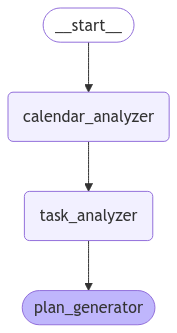

------------------------------
agent_outputs {'planner': {'plan': "Thought: The user needs a study plan for their final exam next week, taking into account their learning preferences, potential ADHD patterns, energy cycles, and environmental preferences.\n\nAction: Analyze the user's profile, calendar, and tasks to create a personalized study plan. Since there are no specific tasks or calendar events provided, I will create a general study plan based on the user's profile.\n\nObservation: The user's key learning preferences include a visual and kinesthetic learning style, short study sessions with frequent breaks, optimal study times in the morning and early afternoon, a quiet and cool environment with natural lighting, and the need for a whiteboard and dual monitors. The user may also benefit from ADHD management strategies and energy level optimization.\n\nPlan:\n\n**FINAL EXAM STUDY PLAN**\n\n*Morning Sessions (9 AM - 12 PM)*\n\n1. **Warm-up (15 min)**: Review previous day's materia

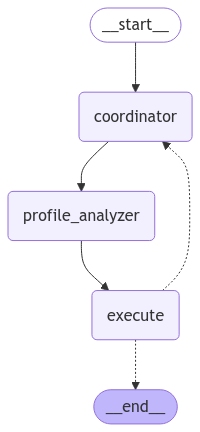

In [ ]:
class JsonCleaner:
    @staticmethod
    def clean_json_content(content: str) -> str:
        """Clean JSON content by removing comments and fixing common issues"""
        # Remove single-line comments (// style)
        content = re.sub(r'\s*//.*$', '', content, flags=re.MULTILINE)

        # Remove multi-line comments (/* ... */ style)
        content = re.sub(r'/\*.*?\*/', '', content, flags=re.DOTALL)

        # Fix trailing commas
        content = re.sub(r',(\s*[}\]])', r'\1', content)

        return content

async def load_json_and_test():
    """Load, clean, and validate JSON files in Colab"""
    print("Please upload your JSON files...")
    uploaded = files.upload()

    patterns = {
        'profile': r'profile.*\.json$',
        'calendar': r'calendar.*\.json$',
        'task': r'task.*\.json$'
    }

    found_files = {
        file_type: next((
            f for f in uploaded.keys()
            if re.match(pattern, f, re.IGNORECASE)
        ), None)
        for file_type, pattern in patterns.items()
    }

    # Verify all files were found
    missing = [k for k, v in found_files.items() if v is None]
    if missing:
        print(f"Error: Could not find files for: {missing}")
        print(f"Uploaded files: {list(uploaded.keys())}")
        return

    print("\nFiles found:")
    for file_type, filename in found_files.items():
        print(f"- {file_type}: {filename}")

    try:
        json_contents = {}
        cleaner = JsonCleaner()

        for file_type, filename in found_files.items():
            print(f"\nProcessing {file_type} file ({filename})...")

            with open(filename, 'r', encoding='utf-8') as f:
                content = f.read()

                # Clean the content
                print("Cleaning JSON content...")
                cleaned_content = cleaner.clean_json_content(content)

                # Validate the cleaned JSON
                try:
                    # Parse to validate
                    parsed = json.loads(cleaned_content)

                    # Store the cleaned content
                    json_contents[file_type] = cleaned_content
                    print("✓ Valid JSON")

                    # Optionally save the cleaned version
                    clean_filename = f"cleaned_{filename}"
                    with open(clean_filename, 'w', encoding='utf-8') as f:
                        json.dump(parsed, f, indent=2)
                    print(f"✓ Saved cleaned version to {clean_filename}")

                except json.JSONDecodeError as e:
                    print("Validation failed!")
                    lines = cleaned_content.split('\n')
                    line_no = e.lineno - 1
                    start = max(0, line_no - 3)
                    end = min(len(lines), line_no + 4)
                    context_lines = lines[start:end]
                    error_context = "\n".join([
                        f"{i+start+1}{' >' if i+start == line_no else '  '} {line}"
                        for i, line in enumerate(context_lines)
                    ])
                    print(f"\nError: {str(e)}")
                    print(f"\nContext:\n{error_context}")
                    return

        print("\nAll files processed successfully!")

        # Fix the profile JSON specifically
        profile_content = json_contents['profile']
        profile_data = json.loads(profile_content)

        # Fix the calendar object
        if 'productivity_tools' in profile_data['profiles'][0]:
            calendar_obj = profile_data['profiles'][0]['productivity_tools']['calendar']
            if 'default_reminder' in calendar_obj:
                # Remove comment and ensure it's a number
                calendar_obj['default_reminder'] = 24

        # Update the profile content
        json_contents['profile'] = json.dumps(profile_data, indent=2)

        print("\nStarting test workflow...")
        llm = NeMoLLaMa(NEMOTRON_4_340B_INSTRUCT_KEY)
        coordinator_output, output = await run_all_system(
            json_contents['profile'],
            json_contents['calendar'],
            json_contents['task']
        )
        return coordinator_output, output

    except Exception as e:
        print(f"\nError processing files: {str(e)}")
        import traceback
        print("\nDetailed error information:")
        print(traceback.format_exc())

FIXED_CALENDAR_STRUCTURE = {
    "platform": "Google Calendar",
    "sync_status": True,
    "default_reminder": 24
}

print("Academic Assistant Test Setup")
print("-" * 50)

coordinator_output, output = await load_json_and_test()

## LLM Output

code for show output in markdown format

In [ ]:
# Your text content
content = str(output)

# Create a console instance
console = Console()

# Create a markdown object
md = Markdown(content)

# Create a panel with the markdown content
panel = Panel(md, title="LLM Output", border_style="blue")

# Print the formatted content
console.print(panel)

╭────────────────────────────────────────────────── LLM Output ───────────────────────────────────────────────────╮
│ Thought: The user needs a study plan for their final exam next week, taking into account their learning         │
│ preferences, potential ADHD patterns, energy cycles, and environmental preferences.                             │
│                                                                                                                 │
│ Action: Analyze the user's profile, calendar, and tasks to create a personalized study plan. Since there are no │
│ specific tasks or calendar events provided, I will create a general study plan based on the user's profile.     │
│                                                                                                                 │
│ Observation: The user's key learning preferences include a visual and kinesthetic learning style, short study   │
│ sessions with frequent breaks, optimal study times in the morning and early afternoon, a quiet and cool         │
│ environment with natural lighting, and the need for a whiteboard and dual monitors. The user may also benefit   │
│ from ADHD management strategies and energy level optimization.                                                  │
│                                                                                                                 │
│ Plan:                                                                                                           │
│                                                                                                                 │
│ FINAL EXAM STUDY PLAN                                                                                           │
│                                                                                                                 │
│ Morning Sessions (9 AM - 12 PM)                                                                                 │
│                                                                                                                 │
│  1 Warm-up (15 min): Review previous day's material using mind maps or flashcards.                              │
│  2 Study Sprint 1 (45 min): Focus on a specific topic using video tutorials or practice problems. Use a timer   │
│    to maintain focus.                                                                                           │
│  3 Break (10 min): Engage in a light physical activity, like stretching or a short walk.                        │
│  4 Study Sprint 2 (45 min): Continue with the same topic or move on to a new one.                               │
│  5 Break (10 min): Relax and recharge with a healthy snack or mindfulness exercise.                             │
│  6 Study Sprint 3 (45 min): Consolidate learning by creating a mind map or summarizing key points.              │
│  7 Long Break (30 min): Engage in a more extended break, such as a workout or a hobby.                          │
│                                                                                                                 │
│ Afternoon Sessions (1 PM - 4 PM)                                                                                │
│                                                                                                                 │
│  1 Review (15 min): Go over the morning's material and address any gaps in understanding.                       │
│  2 Study Sprint 4 (45 min): Focus on a new topic or review a challenging one.                                   │
│  3 Break (10 min): Take a short walk or engage in a light physical activity.                                    │
│  4 Study Sprint 5 (45 min): Continue with the same topic or move on to a new one.                               │
│  5 Break (10 min): Relax and recharge with a healthy snack or mindfulness exercise.                             │
│  6 Study Sprint 6 (45 min): Consolidate learning by cr